In [1]:
import sys
import os
import numpy as np

# Add the src directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from utils import download_data
from mappings import value_mapping
# Now you can import the TimeSeriesDataset class
from TimeSeriesDataset import TimeSeriesDataset as TSD

In [12]:
# initialize dataset by downloading dataset or downloading the data from polity_url
dataset = TSD(categories=['sc'], template_path='../datasets/test.csv')
dataset.add_polities()

Loaded template from ../datasets/test.csv
Downloaded 839 rows


In [3]:
url = "https://seshatdata.com/api/crisisdb/power-transitions/"
pt_df = download_data(url)

Downloaded 3449 rows


In [4]:
PT_types = ['overturn', 'predecessor_assassination', 'intra_elite',
       'military_revolt', 'popular_uprising', 'separatist_rebellion',
       'external_invasion', 'external_interference']
for type in PT_types:
    pt_df[type] = pt_df[type].apply(lambda x: value_mapping[x] if x in value_mapping.keys() else np.nan)

# set nan values to 0
pt_df.fillna(0, inplace=True)

In [13]:
for idx, row in pt_df.iterrows():
    polity = row['polity_id']
    if polity not in dataset.raw.PolityID.unique():
        continue
    year = np.mean([row['year_from'], row['year_to']])
    if year == 0:
        print(row['year_from'], row['year_to'])
    dataset.add_years(polID=polity, year=year)

0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0


In [16]:
dataset.raw = dataset.raw.loc[dataset.raw.Year.notna()]
# delete duplicates
dataset.raw.drop_duplicates(subset=['PolityID', 'Year'], inplace=True)
dataset.raw.reset_index(drop=True, inplace=True)

In [18]:
dataset.download_all_categories()

Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end ye

In [20]:
# remove all rows that have less than 30% of the columns filled in
dataset.remove_incomplete_rows(nan_threshold=0.3)
# build the social complexity variables
dataset.build_social_complexity()

In [22]:
dataset.impute_missing_values()

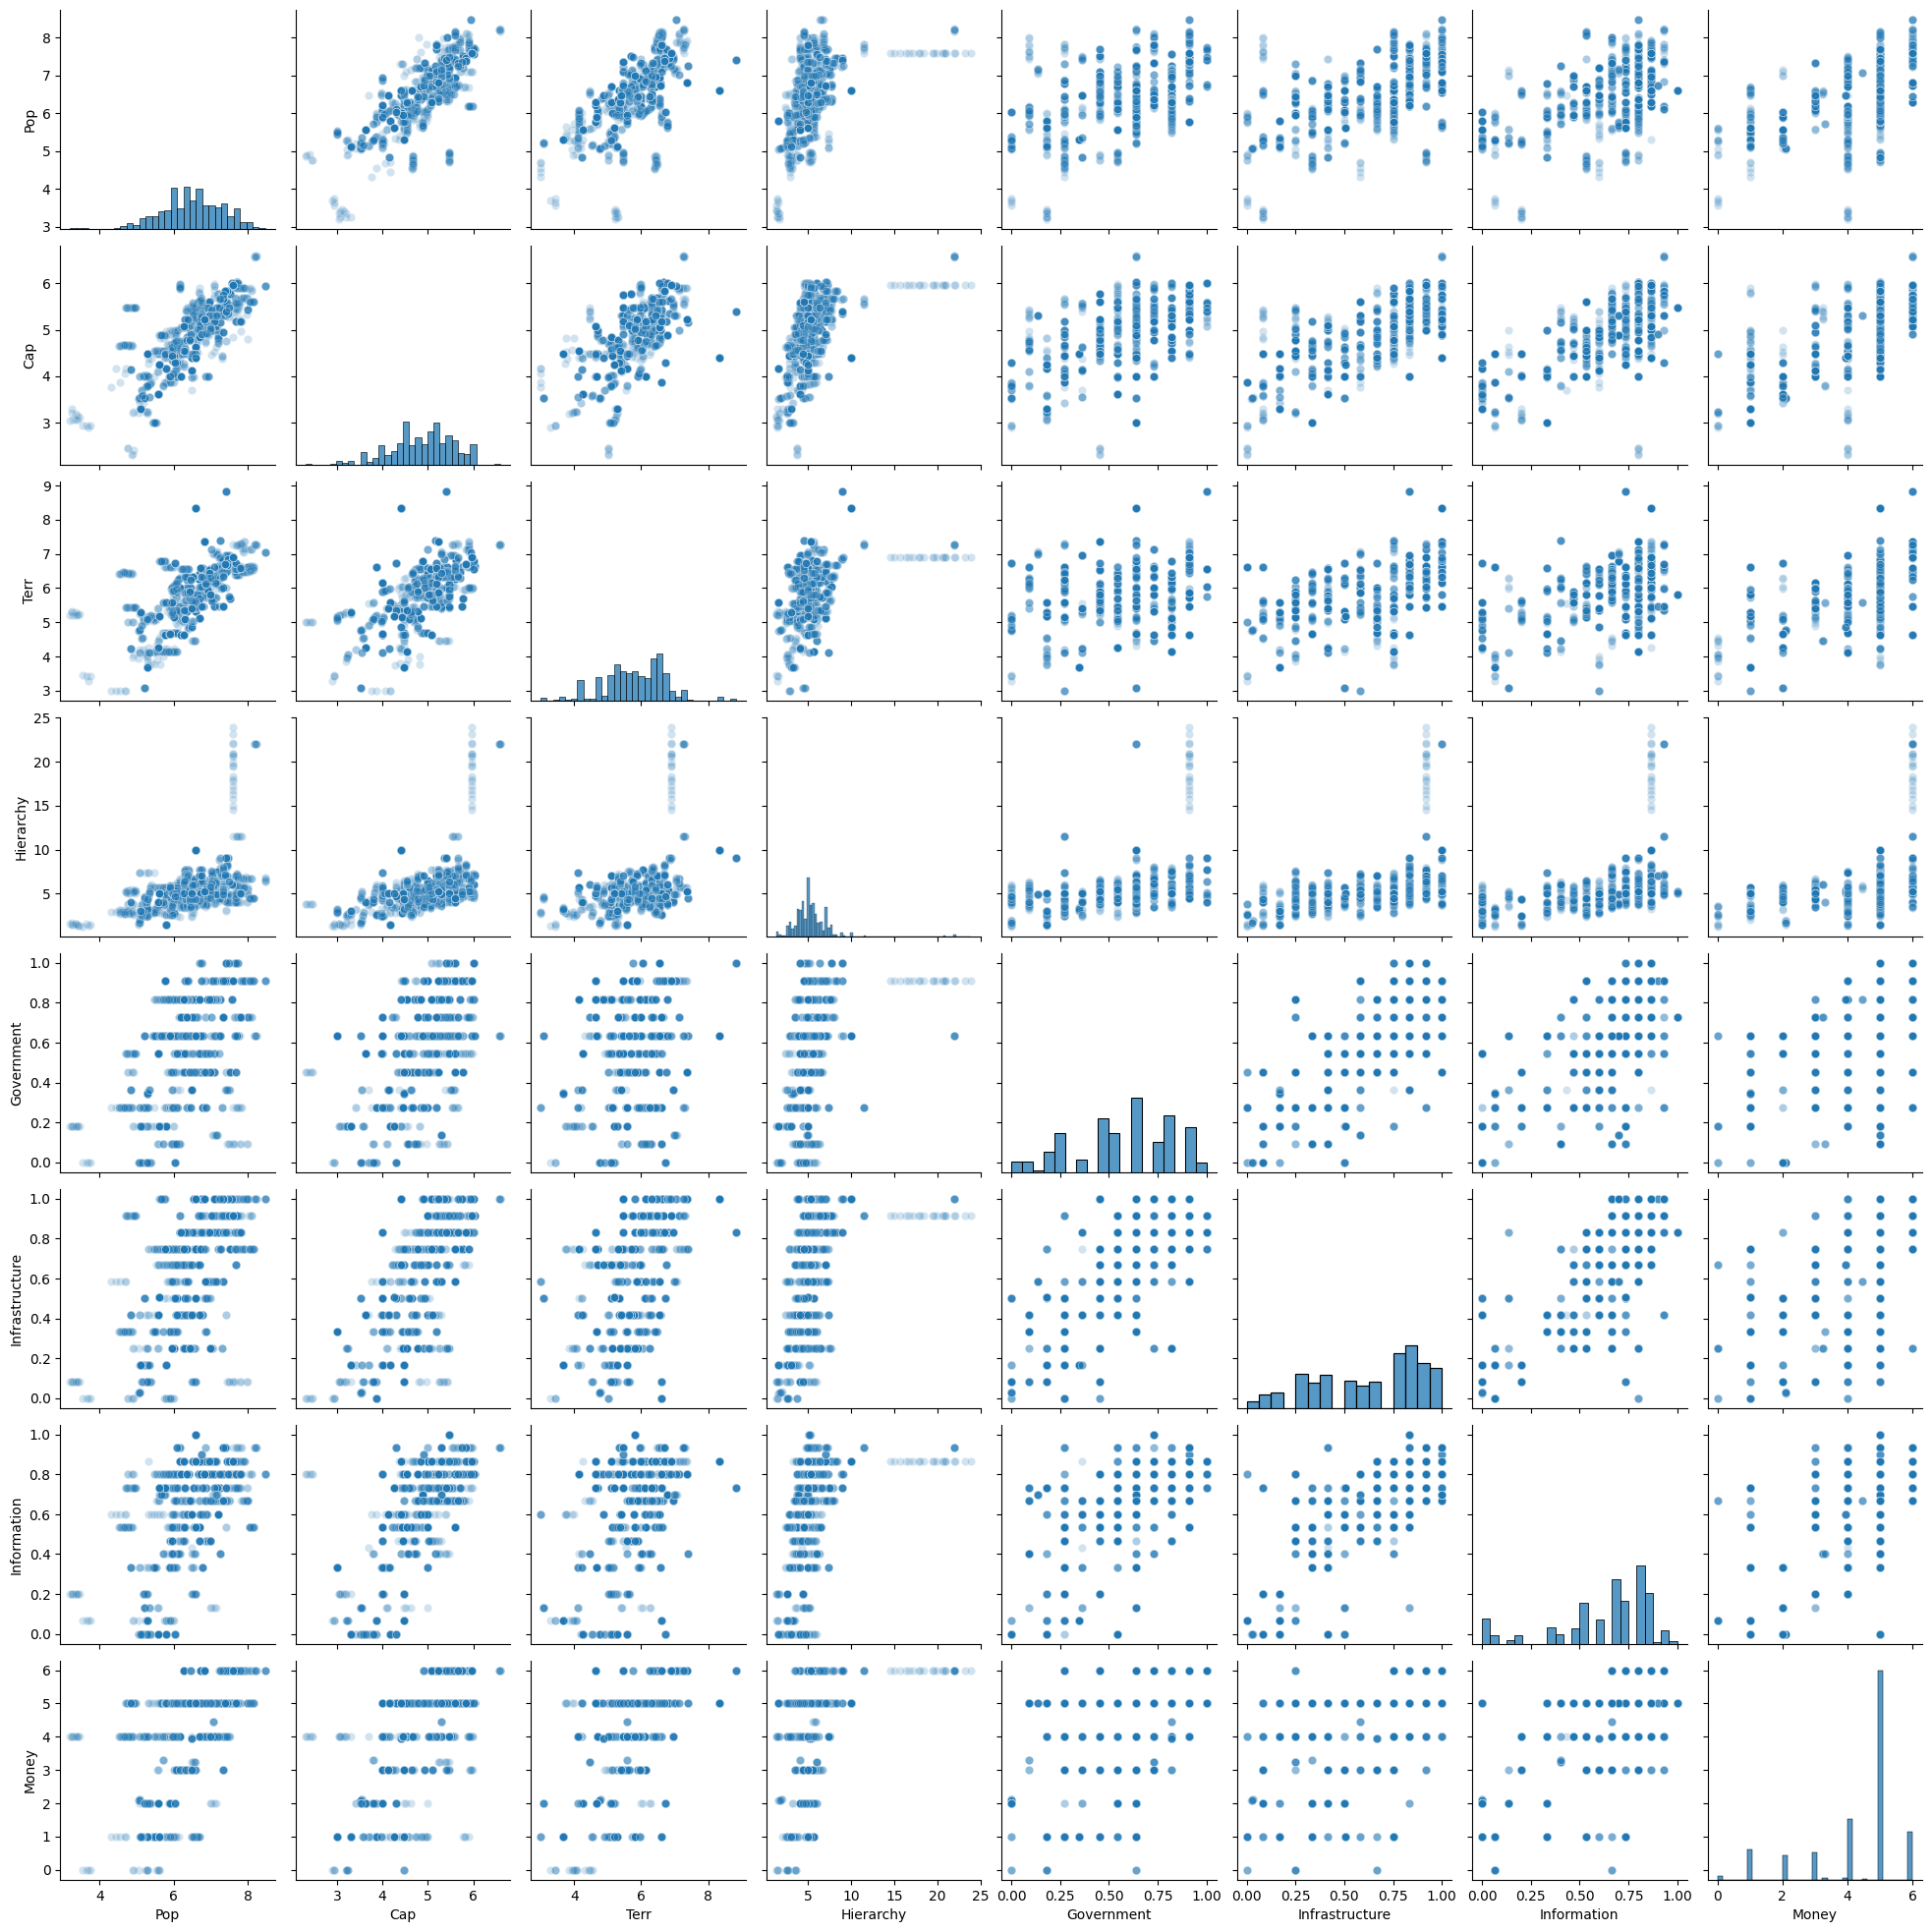

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
sc_columns = ['Pop','Cap','Terr','Hierarchy', 'Government', 'Infrastructure', 'Information', 'Money']
sns.pairplot(dataset.scv_imputed[sc_columns], plot_kws={'alpha': 0.2})
plt.show()